# Astr 257 HR Diagram, Aditya Sengupta

In [2]:
!which python

/Users/adityasengupta/opt/anaconda3/envs/astr257/bin/python


In [3]:
from astropy.io import fits
from astropy.visualization import ZScaleInterval
from matplotlib import pyplot as plt
import numpy as np
from os import path
from photutils.centroids import centroid_sources, centroid_com

In [4]:
datapath = "../../../Project 2--HR Diagram/data/"
getlims = ZScaleInterval().get_limits
def view_as_ds9(img):
    vmin, vmax = getlims(img)
    plt.imshow(img, vmin=vmin, vmax=vmax)

In [5]:
def fname_to_data(fname, calib):
    return np.dstack([fits.open(path.join(datapath, calib, fname + str(i) + ".fits"))[0].data for i in range(3)]).astype(np.float64)

darks, biases, flatsB, flatsV = map(lambda x: fname_to_data(x, "calibration"), ["dark", "bias", "flatB", "flatV"])
landBs, landVs, ngcBs, ngcVs = map(lambda x: fname_to_data(x, "ngc 6819"), ["land_b", "land_v", "ngc_b", "ngc_v"])

In [6]:
# before we do anything else, let's make sure all the exposures are the same
# i threw the headers out when I loaded the data just now, so let's load the fits files again one by one
fits.open(path.join(datapath, "ngc 6819", "ngc_v0.fits"))[0].header['EXPTIME'] # etc
# darks were 60 seconds
# biases were 0 seconds (obv)
# flatsB were 30 seconds
# flatsV were 10 seconds
# landB were 60 seconds
# landV were 60 seconds
# ngcB were 60 seconds
# ngcV were 60 seconds

60

In [18]:
med_dark, med_bias = map(lambda x: np.nanmedian(x, axis=2), [darks, biases])
for i in range(3):
    darks[:,:,i] = med_dark
    biases[:,:,i] = med_bias

mediandiv = lambda data: data / np.nanmedian(data, axis=(0,1))

flatsB_minus_darks = mediandiv((flatsB - darks / 2 - biases) * 2)
flatsV_minus_darks = mediandiv((flatsV - darks / 6 - biases) * 6)

corr_landBs, corr_ngcBs = map(lambda x: (x - darks) / flatsB_minus_darks, [landBs, ngcBs])
corr_landVs, corr_ngcVs = map(lambda x: (x - darks) / flatsV_minus_darks, [landVs, ngcVs])

landB, landV, ngcB, ngcV = map(lambda x: np.nanmedian(x, axis=2), [corr_landBs, corr_landVs, corr_ngcBs, corr_ngcVs])

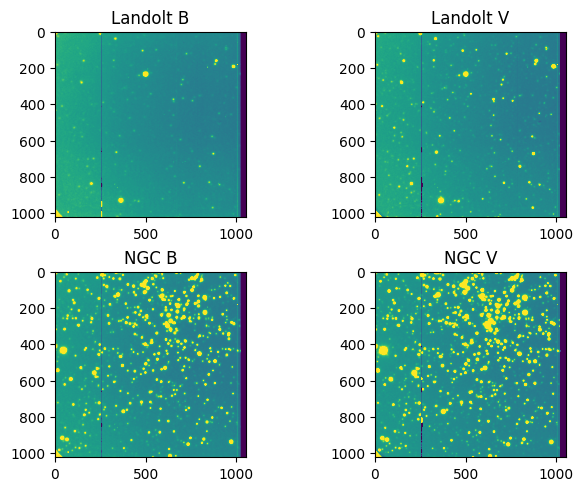

In [24]:
mosaic="AB;CD"
fig = plt.figure(constrained_layout=True)
ax_dict = fig.subplot_mosaic(mosaic)
for (pos, d, n) in zip(['A', 'B', 'C', 'D'], [landB, landV, ngcB, ngcV], ["Landolt B", "Landolt V", "NGC B", "NGC V"]):
    vmin, vmax = getlims(d)
    im = ax_dict[pos].imshow(d, vmin=vmin, vmax=vmax)
    ax_dict[pos].set_title(n)
    # plt.colorbar(im, ax=ax_dict[pos])

In [27]:
fits.writeto("landB_corr.fits", landB, overwrite=True)